In [ ]:
!pip install py7zr
import keras
import numpy as np
import pandas as pd
import os
from PIL import Image
from shutil import rmtree
import cv2
from re import findall
import py7zr
from pathlib import Path
from tqdm import tqdm
from google.colab.patches import cv2_imshow

In [ ]:
make_dir = Path('/content/egohands')
path_to_source_folder = Path('/content/drive/MyDrive/egohands_kitti_formatted_1.7z')

if make_dir.exists(): rmtree(make_dir)
make_dir.mkdir()

if findall('.7z', str(path_to_source_folder)):
    with py7zr.SevenZipFile(path_to_source_folder, mode='r') as z:
        z.extractall('/content/egohands')
    path_to_source_folder = Path('/content/egohands/egohands_kitti_formatted')
elif findall('.zip', str(path_to_source_folder)):
    !unzip $path_to_source_folder -d /content/ASLdataset
    path_to_source_folder = Path('/content/egohands/egohands_kitti_formatted')
else:
    path_to_source_folder = Path(path_to_source_folder)

In [ ]:
path_to_source_folder = Path('/content/egohands/egohands_kitti_formatted')
imgs = list(os.listdir(os.path.join(path_to_source_folder,"images")))
boxes = list(os.listdir(os.path.join(path_to_source_folder,"labels")))

In [ ]:
def splitlist(tokens):
    n = int(len(tokens)/4)
    return [tokens[i:i+4] for i in range(0, len(tokens), 4)]
def txtToArray(path):
    f = open(path)
    tokens=f.read().split()
    # tokens = [i for i in tokens if i != '0' and i!='hand']
    j=0
    ftoken = []
    while j< len(tokens):
        if tokens[j]!='0' and tokens[j]!='hand':
            ftoken.extend([tokens[j],tokens[j+1],tokens[j+2],tokens[j+3]])
            j=j+4
        else:
            j+=1
    tokens = splitlist(ftoken)
    # for i in range(0,len(tokens)): tokens[i]=tokens[i].split(',')
    A=np.array(tokens, dtype=np.int)
    return(A)
def __getitem__(idx):
    pic_count=idx
    i = 1+int(idx/100)
    j = 1+(idx%100)
    # imgStr = "Image"+str(i)+"_"+str(j)+".jpg"
    # boxStr = "Box"+str(i)+"_"+str(j)+".txt"
    # img_path = os.path.join('', "DATA_IMAGES",imgStr)
    # box_path = os.path.join('',"DATA_BOXES",boxStr)
    img_path = str(all_img_path[pic_count])
    box_path = str(str(img_path[:43])+'labels'+str(img_path[49:-3])+'txt')
    i+=1
    box_array = txtToArray(box_path)
    im = Image.open(img_path).convert("RGB")
    boxes = []
    # cv2image = cv2.imread(img_path)
    for k in range(len(box_array)):  #get the bounding boxes for all hands in image with xmin,ymin,xmax,ymax coords
        if box_array[k,2] != 0:
            xmin = box_array[k,0]
            ymin = box_array[k,1]
            xmax = box_array[k,2]
            ymax = box_array[k,3]
            boxes.append([xmin,ymin,xmax,ymax])
    #         cv2image = cv2.rectangle(cv2image,(xmin,ymin),(xmax,ymax),(0,255, 0),2)
    # filename = '/content/images_new_withbox/'+str(img_path[50:-4])+'.jpg'
    # cv2.imwrite(filename, cv2image)
    if len(boxes)==0:
        idx = (idx+1)%4800
        return __getitem__(idx)
    # big_box = [1199,1199,0,0]         #big box is the Region of Interest, essentially a cropping of the image
    # for k in range(len(boxes)):
    #     if boxes[k][0] < big_box[0]:
    #         big_box[0] = boxes[k][0]
    #     if boxes[k][1] < big_box[1]:
    #         big_box[1] = boxes[k][1]
    #     if boxes[k][2] > big_box[2]:
    #         big_box[2] = boxes[k][2]
    #     if boxes[k][3] > big_box[3]:
    #         big_box[3] = boxes[k][3]
    im_array = np.asarray(im)
    # ROI = im_array[big_box[1]:big_box[3],big_box[0]:big_box[2],:]          #a crop of the image
    ROI_Image = Image.fromarray(im_array, 'RGB')
    # ROI_Image.save('/content/images_new/'+str(img_path[50:-4])+'.jpg')
    ROI_Resize = ROI_Image.resize((480,360))
    ROI_npArr = np.asarray(ROI_Resize)
    # ROI_npArr.save('gfg_dummy_pic_2.png')
    # data = im.fromarray(ROI_npArr)
    # data.save('gfg_dummy_pic_3.png')
    #Image_Resize = np.asarray(im.resize((64,64)))
    label = 0
    if i>0 and i<13:
        label = 0    #cards
    if i>12 and i<25:
        label = 1    #chess
    if i>24 and i<37:
        label = 2    #jenga
    if i>36 and i<49:
        label = 3   #puzzle
    return ROI_npArr, label

In [ ]:
X_train = []
Y_train = []
X_test = []
Y_test = []

all_img_path = list((Path('/content/egohands/egohands_kitti_formatted/images')).glob("*"))
print(len(all_img_path))
pbar = tqdm(total=len(all_img_path), bar_format ='{l_bar}{bar}|  {n_fmt}/{total_fmt}  [ Elapsed Time : {elapsed} | ETA : {remaining} ]', leave=True, position=0)
for idx in range(len(all_img_path)):
    i = 1+int(idx/100)  #video 
    j = 1+(idx%100)
    pbar.update(1)
    ROI, activity = __getitem__(idx)
    #lets take first 11 videos as training for each activity
    toTrain = (i-1)%12
    if (toTrain >= 0) and (toTrain <= 10):
        X_train.append(ROI)
        Y_train.append(activity)
    else:
        X_test.append(ROI)
        Y_test.append(activity)

4800


  0%|          |  0/4800  [ Elapsed Time : 00:00 | ETA : ? ]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████|  4800/4800  [ Elapsed Time : 02:57 | ETA : 00:00 ]

In [ ]:
!cp /content/imageswithbox.zip -r /content/drive/MyDrive
!cp /content/imageswithoutbox.zip -r /content/drive/MyDrive

In [ ]:
import os, os.path
from pathlib import Path
path, dirs, files = next(os.walk('/content/images_new_withbox'))
print(len(files))

4800


In [ ]:
X_tr = np.array(X_train)
Y_tr = np.array(Y_train)
X_te = np.array(X_test)
Y_te = np.array(Y_test)

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_tr = to_categorical(Y_tr)
Y_te = to_categorical(Y_te)

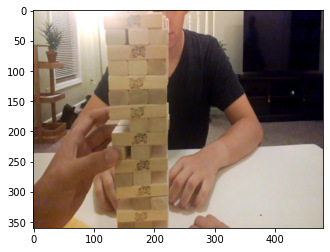

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_tr[1])
plt.show()

In [ ]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout,Activation
model = Sequential()

In [ ]:
model.add(Conv2D(128,kernel_size=3,activation='relu',input_shape=(360,480,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(4 ,activation='softmax'))

In [ ]:
import tensorflow as tf
sgd = tf.keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 358, 478, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 179, 239, 128)    0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 177, 237, 64)      73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 88, 118, 64)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 664576)            0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/hand_rcnn/model_new0.9390909075737') #load the last checkpoint file

In [ ]:
ACCURACY_THRESHOLD = 0.95
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if int(epoch)%100 == 0:  # or save after some epoch, each k-th epoch etc.
            model.save(Path(str('/content/drive/MyDrive/hand_rcnn') + "/model_new" + str(logs.get('accuracy'))))        
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
                print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
                self.model.stop_training = True

In [ ]:
saver = CustomSaver()
history = model.fit(X_tr,Y_tr,validation_data=(X_te,Y_te), callbacks=[saver], epochs=500,shuffle=True)


Epoch 1/500
138/138 [==============================] - 1860s 13s/step - loss: 8.1596 - accuracy: 0.2436 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 2/500
138/138 [==============================] - 1816s 13s/step - loss: 1.3863 - accuracy: 0.2502 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/500
138/138 [==============================] - 1728s 13s/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/500
138/138 [==============================] - 1710s 12s/step - loss: 1.3863 - accuracy: 0.2459 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 5/500
138/138 [==============================] - 1791s 13s/step - loss: 1.3863 - accuracy: 0.2457 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 6/500
138/138 [==============================] - 1801s 13s/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 7/500
138/138 [==============================] - 1742s 13s/step - loss: 1.3863 - accuracy: 0.2443 - val_loss: 1.3863 -

In [ ]:
ACCURACY_THRESHOLD = 0.95
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if int(epoch)%100 == 0:  # or save after some epoch, each k-th epoch etc.
            model.save(Path(str('/content/drive/MyDrive/hand_rcnn') + "/model_new" + str(logs.get('accuracy'))))        
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
                print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
                self.model.stop_training = True

In [ ]:
import pickle
with open(str('/content/drive/MyDrive/hand_rcnn/history.pkle'),'wb') as xyz:
    pickle.dump(history,xyz)
# filehandler = open("history","wb")
# pickle.dump(history,filehandler)

In [ ]:
print('Saving model')
model.save(Path(str('/content/drive/MyDrive/hand_rcnn/model3')))

Saving model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/hand_rcnn/model3/assets


In [ ]:
print(X_te[1].shape)

(32, 32, 3)


In [ ]:
preds = model.predict(X_te)
counter = 0
for i in range(len(preds)):
    preds[i] = np.round(preds[i],0)
    if np.array_equal(Y_te[i],preds[i]):
        counter = counter +1

In [ ]:
video_scores = [0,0,0,0]
for i in range(len(preds)):
    video = int(i/100)
    if np.array_equal(Y_te[i],preds[i]):
        video_scores[video] = video_scores[video]+1
print(video_scores)    #this gives amount of frames correctly classified in each of the 4 videos (cards,chess,jenga,puzzle)

[20, 28, 27, 27]


In [ ]:
def Preprocessimage(new_image_path):
    im = Image.open(new_image_path).convert("RGB")
    im_array = np.asarray(im)
    ROI_Image = Image.fromarray(im_array, 'RGB')
    ROI_Resize = ROI_Image.resize((32,32))
    ROI_npArr = np.asarray(ROI_Resize)
    return ROI_npArr

In [ ]:
newimage = '/content/drive/MyDrive/hand.webp'

preproimage = Preprocessimage(newimage)
print(preproimage.shape)
preds = model.predict(preproimage)


print(preds)

(32, 32, 3)


ValueError: ignored

In [ ]:
!zip -r /content/drive/MyDrive/handrcnnimageswithbox.zip /content/images_new_withbox

  adding: content/images_new_withbox/ (stored 0%)
  adding: content/images_new_withbox/JENGA_LIVINGROOM_H_B_frame_0333.jpg (deflated 1%)
  adding: content/images_new_withbox/JENGA_LIVINGROOM_T_S_frame_2046.jpg (deflated 0%)
  adding: content/images_new_withbox/CHESS_COURTYARD_T_B_frame_2344.jpg (deflated 6%)
  adding: content/images_new_withbox/PUZZLE_COURTYARD_B_S_frame_0323.jpg (deflated 5%)
  adding: content/images_new_withbox/JENGA_OFFICE_T_H_frame_0267.jpg (deflated 0%)
  adding: content/images_new_withbox/CARDS_LIVINGROOM_T_B_frame_0326.jpg (deflated 0%)
  adding: content/images_new_withbox/JENGA_LIVINGROOM_H_B_frame_2220.jpg (deflated 0%)
  adding: content/images_new_withbox/CARDS_LIVINGROOM_S_H_frame_1721.jpg (deflated 0%)
  adding: content/images_new_withbox/CHESS_LIVINGROOM_H_T_frame_0972.jpg (deflated 0%)
  adding: content/images_new_withbox/PUZZLE_OFFICE_T_S_frame_1821.jpg (deflated 0%)
  adding: content/images_new_withbox/PUZZLE_COURTYARD_S_B_frame_2429.jpg (deflated 5%)
 

In [ ]:




newimage = '/content/drive/MyDrive/hand.webp'